In [16]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(ggplot2)
library(GGally)

# Group proposal on developing predictive model in detecting and preventing forest fires in Algerian regions.

**Introduction**

In the Algerian regions (Northern Africa) of **Bejaia** and **Sidi Bel-abbes** during the period, between June 2012 and September 2012, forest fires ravaged an estimated 20,000 hectares of land. 
Our project aims to construct a prediction model for forest fires and we will use the Algerian Forest Fires Dataset, which contains data from two sub-regions.

Our target variable for this project will be the Classes label fromthe dataset, and we will perform K-nearest neighbours classification algorithm to answer the predictive question.

**Brief data explanation**
* Temperature: Degree Celsius
* RH: Relative Humidity (%)
* Ws: Wind speed (km/h)
* ISI (Initial Spread Index): estimation of the anticipated spread of a fire that is based on FFMC. 
* FFMC (fine fuel moisture code): the moisture content based on litter or other fine fuels. 
* DMC (Duff Moisture Code) and DC (Drought Code): is the average rating of moisture in the organic layers of the forest.
* BUI (Buildup Index): the total amount of fuel that can be used for a combustion reaction, this number is based on the DMC and the DC. 
* FWI (Fire Weather Index): the rating of the strength of the fire.

# Methods

## Beginning steps
* Reading data from web-source and converting the columns into correct types for further coding purposes. 
* Wrangling and tidying the data by : Firstly, extracting the two subregions dataset with a mutated column "Region". Secondly, filtering out rows without NA values and non clssified 'Classes' label. Thirdly, combining the tidied datasets into one dataset to work on the predicive problem for the overall Algerian regions.


In [17]:
#coding part: reading data from web and rbind() them after filtering out necessary information

B_forestfire_data <- read_csv("https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                slice(1:124)%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"),
                      Region = "Bejaia")%>%
                filter(Classes != 'Classes',
                      !is.na(Classes))
                

S_forestfire_data <- read_csv("https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv", skip = 126, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"),
                      Region = "Sidi Bel-abbes")%>%
                filter(Classes != 'Classes',
                      !is.na(Classes))

#combining two dataset into one for tidyness
forest_fire_data <- rbind(B_forestfire_data, S_forestfire_data)

head(forest_fire_data, n = 3) #table visualization

Warning message:
“16 parsing failures.
row         col   expected      actual                                                                                                       file
123 day         a number   -           'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
123 NA          14 columns 1 columns   'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 day         a number   day         'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 year        a number   year        'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 Temperature a number   Temperature 'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
... ........... .......... ........... ..............................................

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,June,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
2,June,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
3,June,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia


## Exploratory Steps

* Initially splitting the dataset into 0.76 training set and 0.24 testing set based on the size of the original dataset, and using only the training dataset throughout the model training process.
* Including set.seed() in necessary cells to ensure the data is reproducible.
* Creating visualization by ggpairs() function to check whether the data is imbalanced as well as determine the predictors for the model specification. 
* Adding plots of predictors respectively for the better undertsanding and demonstration on the data distribution. 

In [18]:
#Verifying the size of dataset
nrow(forest_fire_data)

[1] 243

##### This is a relatively small dataset based on its size. Therefore we decide to slice the data with 76% for the training set and 24% for the testing set to ensure the training set is large enough while still having sufficient data for the testing set to test the accuracy

In [19]:
set.seed(100) 
#data spliiting 
forest_split <- initial_split(forest_fire_data, prop = 0.76, strata = Classes)

training <- training(forest_split)
testing <- testing(forest_split)

##### After splitting the data into testing and training sets, we visualize the relationships among different variables by ggpairs(). This allows us to see which predictors would be the strong influencer and helps us to decide how many of them should be included in the model recipe.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



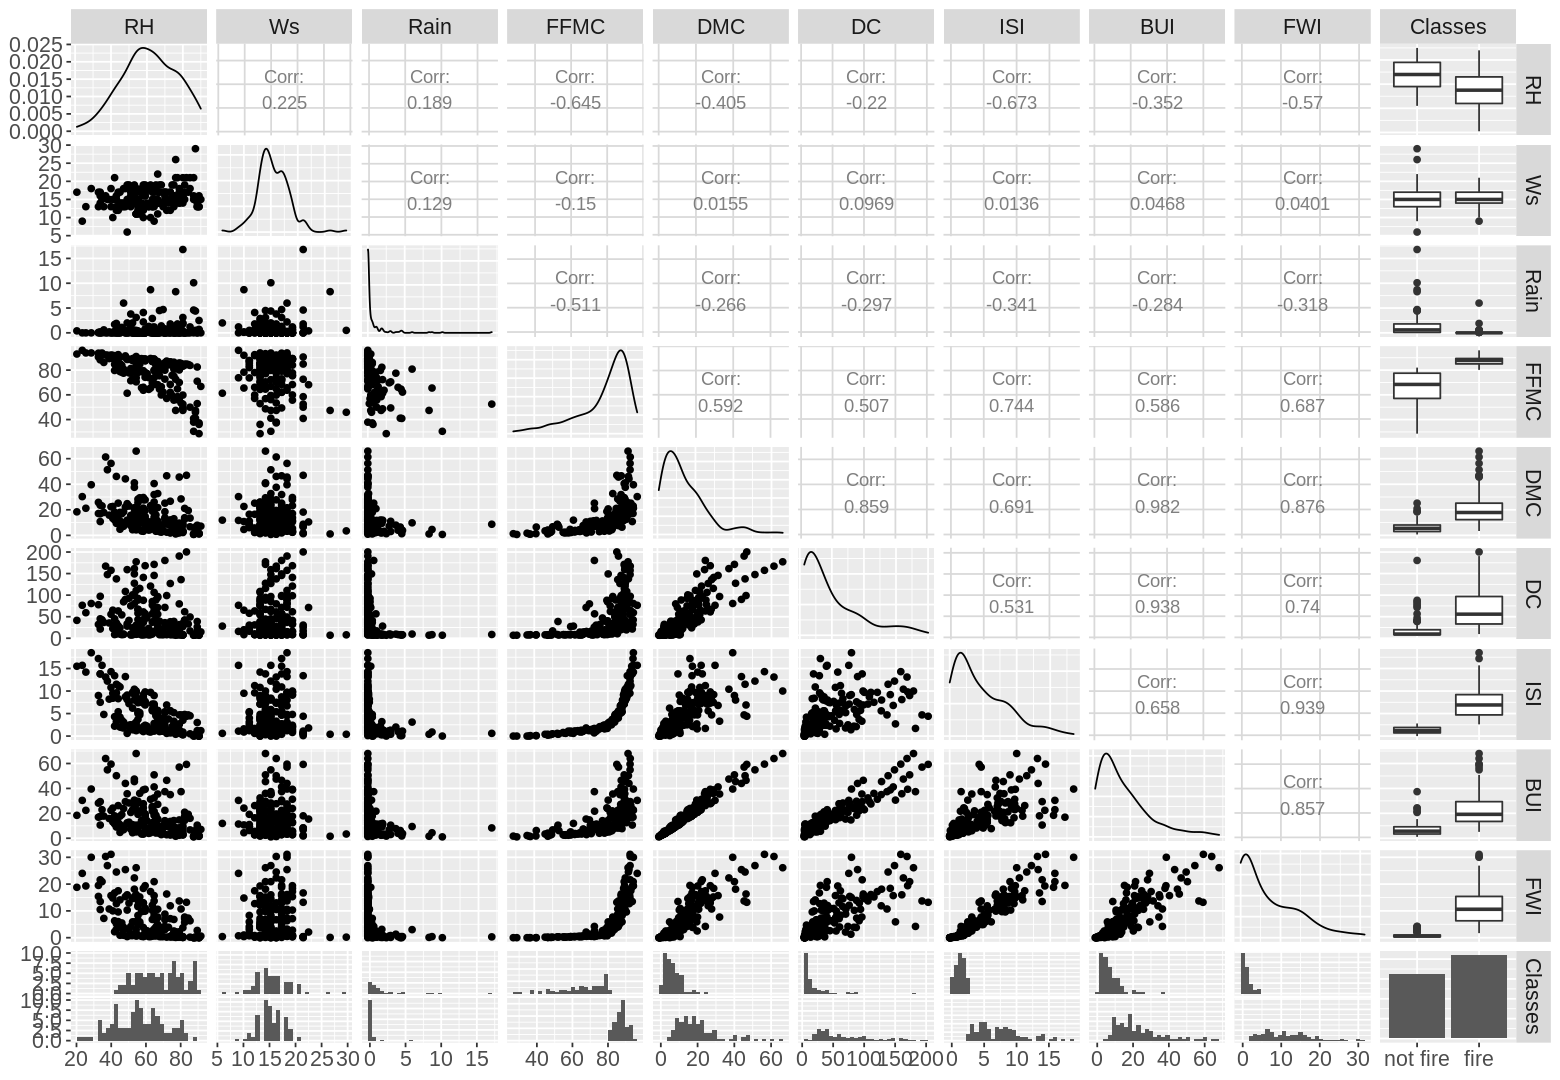

In [20]:
options(repr.plot.width = 13, repr.plot.height = 9)

pairs_plot <- training %>%
        select(RH:Classes) %>%
        ggpairs()+
        theme(text = element_text(size = 16))

pairs_plot

**Relative Humidity** graphs and **Wind Speed** graphs are not very helpful to our project as they don't give us clear insight on the relationship with the different variables. As most have weak correlations or no relationship at all. 

The **ISI vs BUI** graph shows a moderately positive linear relationship; there are points that would be a little far from the line of best fit. This means that as the ISI increases the BUI also increases. A higher ISI can be a predictor of a higher BUI value as well.

The **ISI vs FWI** graph shows a strong positive linear relationship. Most points are close to where the line of best fit would be and as the ISI increases the FWI increases as well. Similar to the ISI vs BUI graph a higher ISI can be a predictor of a high FWI value.

**The last row of the graphs are classes with all the different variables. However it is tricky to analyze these graphs due to its size. Therefore, we picked four graphs $(FWI, FFMC, BUI, ISI)$ to focus on in order to further study the relationships of the histograms. We chose the graphs based on a rough idea of which graphs seem to have a relationship with the classes variable.** 


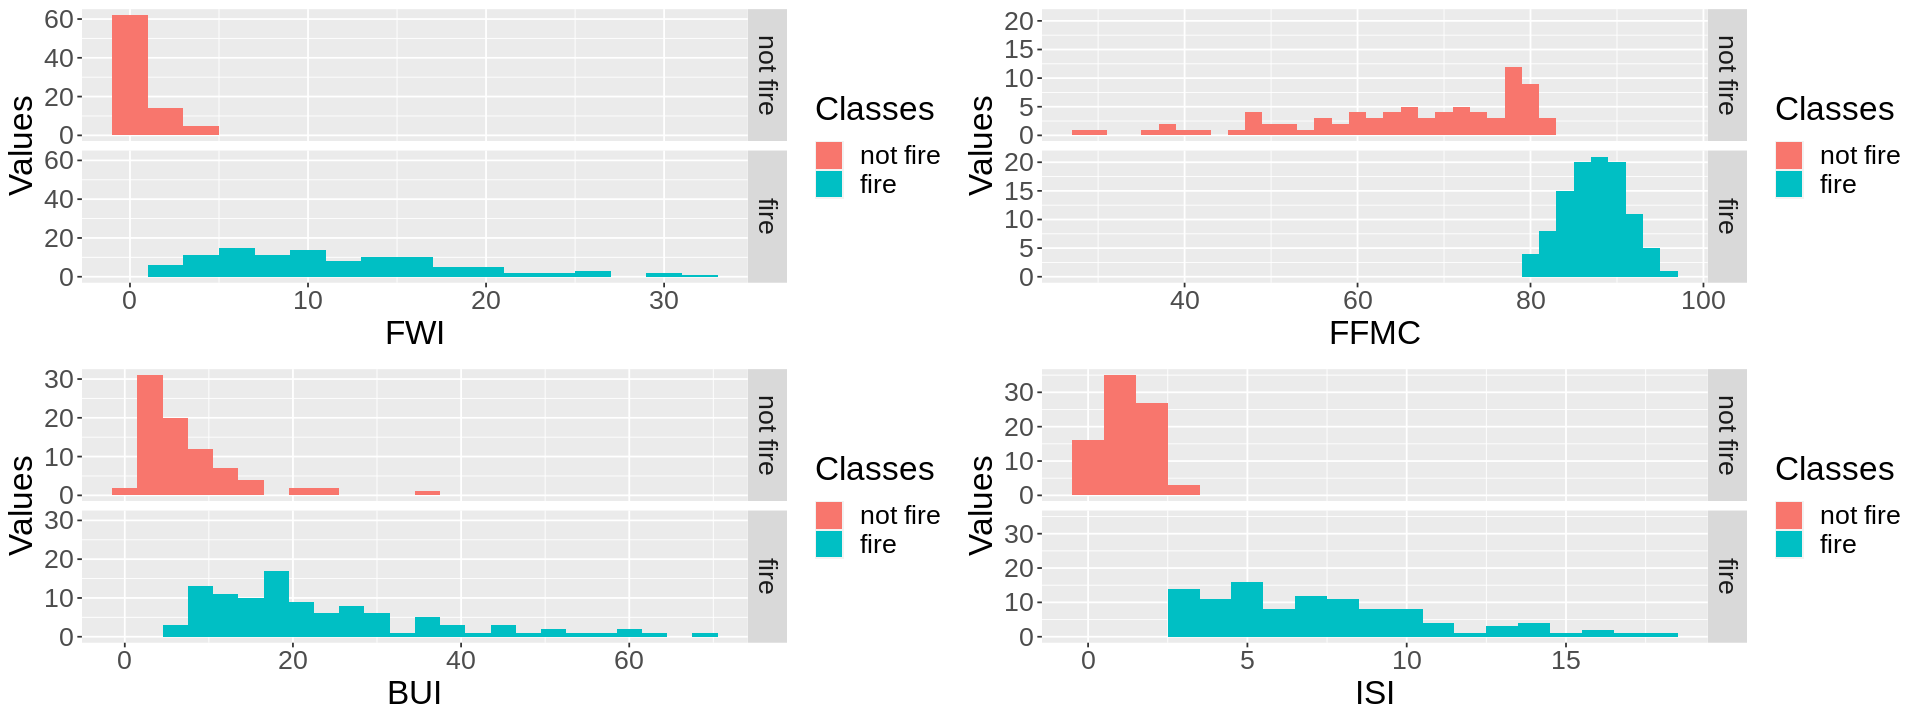

In [21]:
options(repr.plot.width = 16, repr.plot.height = 6)
#ploting the four parameters against Classes respectivey with histogram

fwi_histogram <- ggplot(training, aes(x = FWI,fill = Classes))+
        geom_histogram(binwidth=2)+
        facet_grid(Classes~.)+
        labs(x = "FWI", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

ffmc_histogram <- ggplot(training, aes(x = FFMC,fill = Classes))+
        geom_histogram(binwidth=2)+
        facet_grid(Classes~.)+
        labs(x = "FFMC", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

bui_histogram <- ggplot(training, aes(x = BUI,fill = Classes))+
        geom_histogram(binwidth=3)+
        facet_grid(Classes~.)+
        labs(x = "BUI", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

isi_histogram <- ggplot(training, aes(x = ISI,fill = Classes))+
        geom_histogram(binwidth=1)+
        facet_grid(Classes~.)+
        labs(x = "ISI", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

plot_grid(fwi_histogram, ffmc_histogram, bui_histogram, isi_histogram, ncol = 2)

**FWI** graph shows us that all of the $not-fire$ cases range from the FWI value of zero until 5. While $fire$ cases range from about 2 until above 30. 
**Lower FWI can be a predictor for no fire cases**.
The **FFMC** plot shows that most $fire$ cases have higher FFMC values from 80 to about 100, while $not-fire$ cases vary from having FFMC values as low as about 30 until 80. 
 **A higher FFMC value can be a predictors for fire cases**.

The **BUI** graph shows that a lower BUI usually means $not-fire$ with the values ranging from 0 to 15 (there are some exceptions where some cases have BUI values of 20 and 35), but **higher BUI value can likely indicate fire cases.**
**ISI** graph shows us a similar pattern to the FWI graph and BUI graph where $not-fire$ cases **have lower ISI values while $fire$ cases have a higher ISI values**.

## Model Training and Tuning
* Creating model specification with tune() (in order to select the best K from following analysis steps).
* Including the selected predictors from the exploratory steps which are FWI, FFMC, BUI, ISI respectively in recipe.
* Performing 5-fold cross-validation on the training dataset and chaining together data analysis steps by workflow()
* Picking a K value that yields the highest accuracy and doesn't decrease accuracy too much when changing it to the nearby ones.

In [22]:
#models and recipes for both regions. 
set.seed(50)

#imporving value of K with tune() in the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

#recipe with selected predictors
f_recipe <- recipe(Classes ~ FWI + FFMC + BUI + ISI, data = training) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

In [23]:
set.seed(50)

#5 fold cross-validation on training set
fires_fold <- vfold_cv(training, v = 5, strata = Classes)

#fit the model with a range of 10 K values 
knn_results<- workflow() %>%
    add_recipe(f_recipe)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = fires_fold, grid= 10) %>%
    collect_metrics()

#extracting accuracy estimations results
accuracies <- knn_results %>%
        filter(.metric == 'accuracy')

#picking the best K from the plot, will be grided with the other plot below
k_plot <- ggplot(accuracies, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("K Vs. Accuracy 1")

! Fold1: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold2: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold3: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold4: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold5: internal: No observations were detected in `truth` for level(s): 'Classe...



#### We're repeating this process a second time with a different set.seed() to see if different seed would influence the best K accuracy estimation.

! Fold1: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold2: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold3: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold4: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold5: internal: No observations were detected in `truth` for level(s): 'Classe...



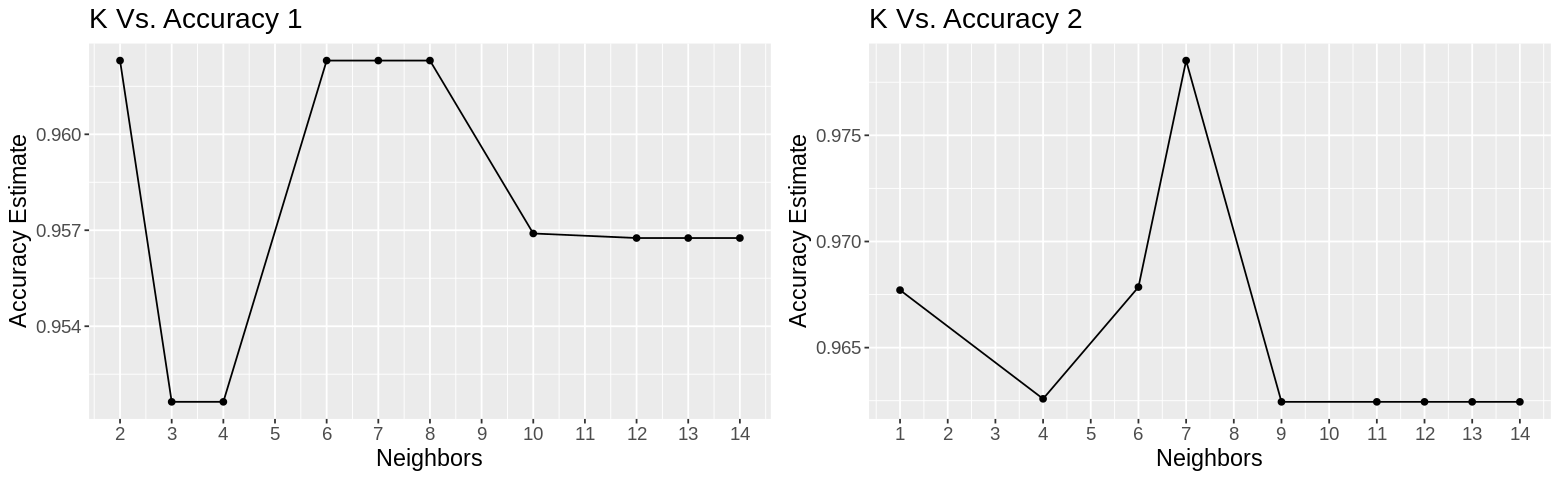

In [24]:
options(repr.plot.width = 13, repr.plot.height = 4)

#steps are the same as previous cell, but we are using a different seed to see if any difference would occur.
set.seed(40)

fires_fold_2 <- vfold_cv(training, v = 5, strata = Classes)

knn_results_2 <- workflow() %>%
    add_recipe(f_recipe)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = fires_fold_2, grid= 10) %>%
    collect_metrics()

accuracies_2 <- knn_results_2 %>%
        filter(.metric =='accuracy')

k_plot_2 <- ggplot(accuracies_2, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("K Vs. Accuracy 2") 

#Griding two plots together
plot_grid(k_plot,k_plot_2,ncol=2)

##### Two visualizations look different, but they both contains k = 7 for the highest accuracy and 4 in the lower accuracy domain. Therefore We'd choose 7 to be the K-nearest neighbour value for next prediction/evaluation analysis on the testing set.

## Evaluating Accuracy
* Retraining the model specification with K = 7
* Predicting the labels on testing set to evaluate classifier's accuracy.

In [25]:
#Making new model specification and retraining classifier with the K = 9 

fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
        set_engine("kknn")%>%
        set_mode("classification")

fire_fit <- workflow()%>%
        add_recipe(f_recipe)%>%
        add_model(fire_spec)%>%
        fit(data = training)


#Evaluating accuracy of classifier on testing dataset

fire_prediction <- predict(fire_fit, testing)%>%
        bind_cols(testing)

head(fire_prediction, n = 4) #preview on the output

#Computing the accuracy

fire_metrics <- fire_prediction %>%
            metrics(truth = Classes, estimate = .pred_class)

.pred_class,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
not fire,3,June,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
fire,7,June,2012,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire,Bejaia
not fire,10,June,2012,28,79,12,0.0,73.2,9.5,46.3,1.3,12.6,0.9,not fire,Bejaia
fire,11,June,2012,31,65,14,0.0,84.5,12.5,54.3,4.0,15.8,5.6,fire,Bejaia


## Visualization of the Analysis
* Outputing the accuracy statistics in a matrix. 
* Ploting the decision boundaries for the calssificartion result. (Since ther are more than two predictors, two decision boundaries plots will be created)


In [26]:
#accuracy matrix
fire_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9649123
kap,multiclass,0.9287500


Accuracy is 96.5%

In [27]:
confusion <- conf_mat(fire_prediction, truth = Classes, estimate = .pred_class)
confusion

          Truth
Prediction not fire fire Classes
  not fire       24    1       0
  fire            1   31       0
  Classes         0    0       0

,FWI,FFMC,BUI,ISI
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000000,28.6,17,4.79
2,0.3141414,28.6,17,4.79
3,0.6282828,28.6,17,4.79
4,0.9424242,28.6,17,4.79
5,1.2565657,28.6,17,4.79
6,1.5707071,28.6,17,4.79


,.pred_class,FWI,FFMC
,<fct>,<dbl>,<dbl>
1,not fire,0.0000000,28.6
2,not fire,0.3141414,28.6
3,not fire,0.6282828,28.6


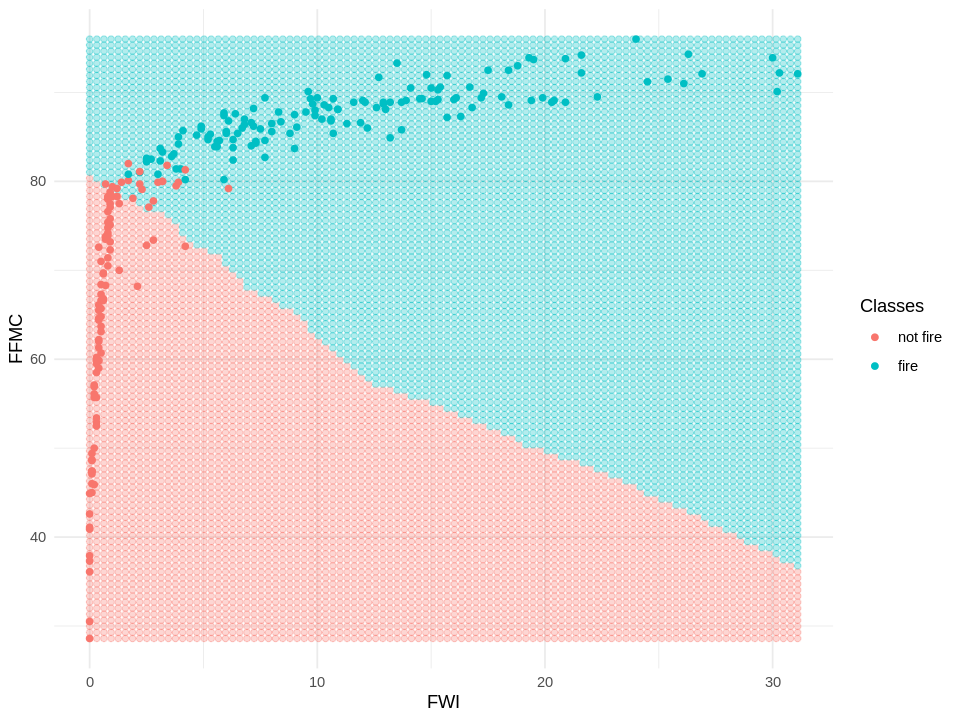

In [36]:
#plot a decision boundaries : refer to @679 piazza post
FWI_seq <- seq(from = min(forest_fire_data$FWI, na.rm = TRUE), 
             to = max(forest_fire_data$FWI, na.rm = TRUE), 
             length.out = 100)
FFMC_seq <- seq(from = min(forest_fire_data$FFMC, na.rm = TRUE), 
             to = max(forest_fire_data$FFMC, na.rm = TRUE), 
             length.out = 100)

grid_points <- expand.grid(FWI = FWI_seq,
                           FFMC = FFMC_seq)
testing_FWI_FFMC <- select(testing, FWI, FFMC)

new_data <- data.frame(grid_points, BUI= 17.21, ISI = 4.79)
head(new_data)
## Predicts the class for each of the 10,000 points in the grid.
grid_predicted <- fire_fit %>%
                    predict(new_data = new_data) %>%
                    cbind(grid_points) 
head(grid_predicted, n=3)

## Plot the decision boundaries.
## If you see dots instead of an area, you can try increasing the number of points in the sequences above.
## You can also play with the size argument in `geom_point()`.

options(repr.plot.width = 8, repr.plot.height = 6)
decesion_boundary_plot <-
grid_predicted %>%
    ggplot(aes(x = FWI, 
               y = FFMC, 
               color = .pred_class)) + 
    geom_point(alpha = 0.3) + 
    geom_point(data = forest_fire_data,
               aes(x = FWI, 
                   y = FFMC, 
                   color = Classes)) + 
    theme_minimal() + 
    labs(x = "FWI", 
         y = "FFMC",
         colour = "Classes")
decesion_boundary_plot



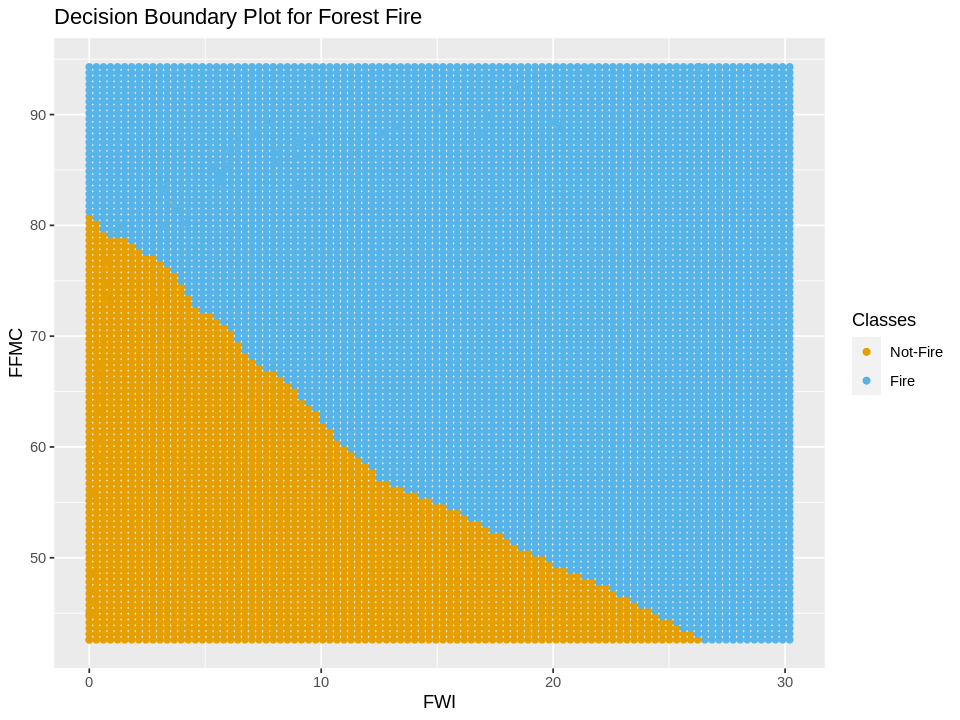

In [52]:
testing_FWI_FFMC <- select(testing, FWI, FFMC, Classes) 

FWI_seq <- seq(from = min(testing_FWI_FFMC$FWI, na.rm = TRUE), 
             to = max(testing_FWI_FFMC$FWI, na.rm = TRUE), 
             length.out = 100)
FFMC_seq <- seq(from = min(testing_FWI_FFMC$FFMC, na.rm = TRUE), 
             to = max(testing_FWI_FFMC$FFMC, na.rm = TRUE), 
             length.out = 100)


asgrid <- data.frame(expand.grid(FWI= FWI_seq, FFMC= FFMC_seq), BUI= 17.21, ISI=4.79)

pred_grid <- predict(fire_fit, asgrid)

prediction_table <-  bind_cols(pred_grid, asgrid) %>%
    rename(Classes = .pred_class)

cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")

pred_map_plot <-  ggplot()+
    geom_point(data= testing_FWI_FFMC, mapping= aes(x= FWI, y= FFMC, color= Classes)) +
    geom_point(data= prediction_table, mapping=aes(x= FWI, y= FFMC, color= Classes))+
    labs(x= "FWI", y= "FFMC", color= "Classes") +
    scale_color_manual(labels = c("Not-Fire", "Fire"), values= cbPalette)+
    ggtitle("Decision Boundary Plot for Forest Fire")
pred_map_plot


In [29]:
testing %>%
summarize(mean(BUI), mean(ISI))

mean(BUI),mean(ISI)
<dbl>,<dbl>
17.21404,4.798246


Summary:
The classifier was able to predict that a fire does not occur 24/25 times correctly and was able to predict a fire occuring 31/32 times correctly.As such, the classifer predicted fire will occur when there was no fire 1/24 times and no fire when there was a fire 1/32 times This means that the classifier had a combined correct accuracy percentage of 96.5%.

## (needs to change it to discussion part of the project report)
 Expected Outcomes and Significance 

We expect to find that this model will have the ability to predict the existence of future forest fires with an accuracy above 85%, based on the FWI, FFMC, BUI, and ISI of the region. This prediction model can be applied proactively as a means to prevent future forest fires in vulnerable regions, thus making it a valuable environmental tool. 

Scaffolding from this model can be extrapolated to fit the model for regions other than Bejaia and Sidi Bel-abbes, as well as countries other than Algeria. Furthermore, new predictors (that are not included in the data set) could be introduced into the model in the future to see if they would provide better accuracy.

* !!!observed that set.seed() also had influence over K-value, when set.seed is ..., the best K is ..., and when set.seed() is ..., the best K changes to ...
This could be a further exploratory step to .... .... !!! edition needed